In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [2]:
# Load the datasets
train_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_Train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_test.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_Validation.csv')

In [3]:
# Function to preprocess datasets
def preprocess_data(df):
    df['local_time'] = pd.to_datetime(df['local_time'])
    for time_unit in ['Year', 'Month', 'Day', 'Hour']:
        df[time_unit] = getattr(df['local_time'].dt, time_unit.lower())
    return df.drop('local_time', axis=1)

In [4]:
def add_cyclical_features(df, col_name, max_val):
    if col_name in df.columns:
        df[col_name + '_sin'] = np.sin(2 * np.pi * df[col_name] / max_val)
        df[col_name + '_cos'] = np.cos(2 * np.pi * df[col_name] / max_val)
    return df

#'Hour', 'Day', and 'Month' created
for df in [train_df, validation_df, test_df]:
    df = add_cyclical_features(df, 'Hour', 23)
    df = add_cyclical_features(df, 'Day', 31)
    df = add_cyclical_features(df, 'Month', 12)

In [5]:
def add_lagged_features(df, feature_cols, n_lags=3):
    for feature in feature_cols:
        for lag in range(1, n_lags + 1):
            df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    return df.dropna().reset_index(drop=True)

# Preprocess all datasets
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)
validation_df = preprocess_data(validation_df)

# Specifying the features to lag
features_to_lag = ['Average_Temp', 'MW']  # Add other relevant features as needed

# Applying the function to the datasets
train_df = add_lagged_features(train_df, features_to_lag, n_lags=3)
validation_df = add_lagged_features(validation_df, features_to_lag, n_lags=3)
test_df = add_lagged_features(test_df, features_to_lag, n_lags=3)

In [6]:
from sklearn.preprocessing import PolynomialFeatures

# Creating polynomial and interaction features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Applying transformation to all datasets.
train_features = train_df.drop(columns=['MW'])
validation_features = validation_df.drop(columns=['MW'])
test_features = test_df.drop(columns=['MW'])

X_train_poly = poly.fit_transform(train_features)
X_validation_poly = poly.transform(validation_features)
X_test_poly = poly.transform(test_features)


feature_names = poly.get_feature_names_out(input_features=train_features.columns)


y_train = train_df['MW']
y_validation = validation_df['MW']
y_test = test_df['MW']

In [7]:
# Evaluation Function

def calculate_metrics(actual, predicted, lower_bound=0, upper_bound=100, iqr_multiplier=1.5):
    # Excluding negative actual values if considered invalid
    valid_indices = actual > lower_bound
    actual = actual[valid_indices]
    predicted = predicted[valid_indices]

    # Calculate MAE and RMSE
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Thresholding for outlier exclusion based on IQR
    q1, q3 = np.percentile(actual, [25, 75])
    iqr = q3 - q1
    outlier_threshold_upper = q3 + (iqr * iqr_multiplier)
    outlier_threshold_lower = q1 - (iqr * iqr_multiplier)

    valid_indices_for_mape = (actual >= outlier_threshold_lower) & (actual <= outlier_threshold_upper)
    filtered_actual = actual[valid_indices_for_mape]
    filtered_predicted = predicted[valid_indices_for_mape]

    # Calculate Modified MAPE with capped at 100%
    if len(filtered_actual) > 0:
        percentage_errors = np.abs((filtered_predicted - filtered_actual) / filtered_actual) * 100
        percentage_errors = np.clip(percentage_errors, None, upper_bound)  # Cap percentage errors at upper_bound (100%)
        mape = np.mean(percentage_errors)
    else:
        mape = np.nan

    # Calculate sMAPE
    smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    return mae, mape, smape, rmse

In [ ]:
import xgboost as xgb

# Define the XGBoost regressor with specified parameters
xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    enable_categorical=False,
    missing=np.nan,  # Handle missing values
    alpha=0,
    reg_lambda=1  # Corrected parameter name
)

# Train the model
xg_reg.fit(X_train_poly, y_train)

# Predictions
y_train_pred = xg_reg.predict(X_train_poly)
y_validation_pred = xg_reg.predict(X_validation_poly)
y_test_pred = xg_reg.predict(X_test_poly)

# Evaluation on the validation dataset
mae_val, mape_val, smape_val, rmse_val = calculate_metrics(y_validation, y_validation_pred)

print(f"Validation MAE: {mae_val}")
print(f"Validation MAPE: {mape_val}")
print(f"Validation sMAPE: {smape_val}")
print(f"Validation RMSE: {rmse_val}")


# Evaluation on the validation dataset
mae_test, mape_test, smape_test, rmse_test = calculate_metrics(y_test, y_test_pred)
test_metrics = calculate_metrics(y_test, y_test_pred)

print(f"Test MAE: {mae_test}")
print(f"Test MAPE: {mape_test}")
print(f"Test sMAPE: {smape_test}")
print(f"Test RMSE: {rmse_test}")


Validation MAE: 7.869289939769292
Validation MAPE: 12.790476823927278
Validation sMAPE: 12.983955965292227
Validation RMSE: 18.271015618766032
Test MAE: 6.047303561970162
Test MAPE: 6.581686534360384
Test sMAPE: 8.457832609472684
Test RMSE: 14.160573450458681


In [ ]:
xg_reg.save_model('/content/drive/MyDrive/Saved_trained_models/xgboost_model_final.json')


In [9]:
import xgboost as xgb
loaded_xg_reg = xgb.XGBRegressor()

# Load the trained model
loaded_xg_reg.load_model('/content/drive/MyDrive/Saved_trained_models/xgboost_model_final.json')

In [12]:
# Predictions
y_train_pred = loaded_xg_reg.predict(X_train_poly)
y_validation_pred = loaded_xg_reg.predict(X_validation_poly)
y_test_pred = loaded_xg_reg.predict(X_test_poly)

# Evaluation on the validation dataset
mae_val, mape_val, smape_val, rmse_val = calculate_metrics(y_validation, y_validation_pred)

print(f"Validation MAE: {mae_val}")
print(f"Validation MAPE: {mape_val}")
print(f"Validation sMAPE: {smape_val}")
print(f"Validation RMSE: {rmse_val}")


# Evaluation on the validation dataset
mae_test, mape_test, smape_test, rmse_test = calculate_metrics(y_test, y_test_pred)
test_metrics = calculate_metrics(y_test, y_test_pred)

print(f"Test MAE: {mae_test}")
print(f"Test MAPE: {mape_test}")
print(f"Test sMAPE: {smape_test}")
print(f"Test RMSE: {rmse_test}")

Validation MAE: 7.869289939769292
Validation MAPE: 12.790476823927278
Validation sMAPE: 12.983955965292227
Validation RMSE: 18.271015618766032
Test MAE: 6.047303561970162
Test MAPE: 6.581686534360384
Test sMAPE: 8.457832609472684
Test RMSE: 14.160573450458681


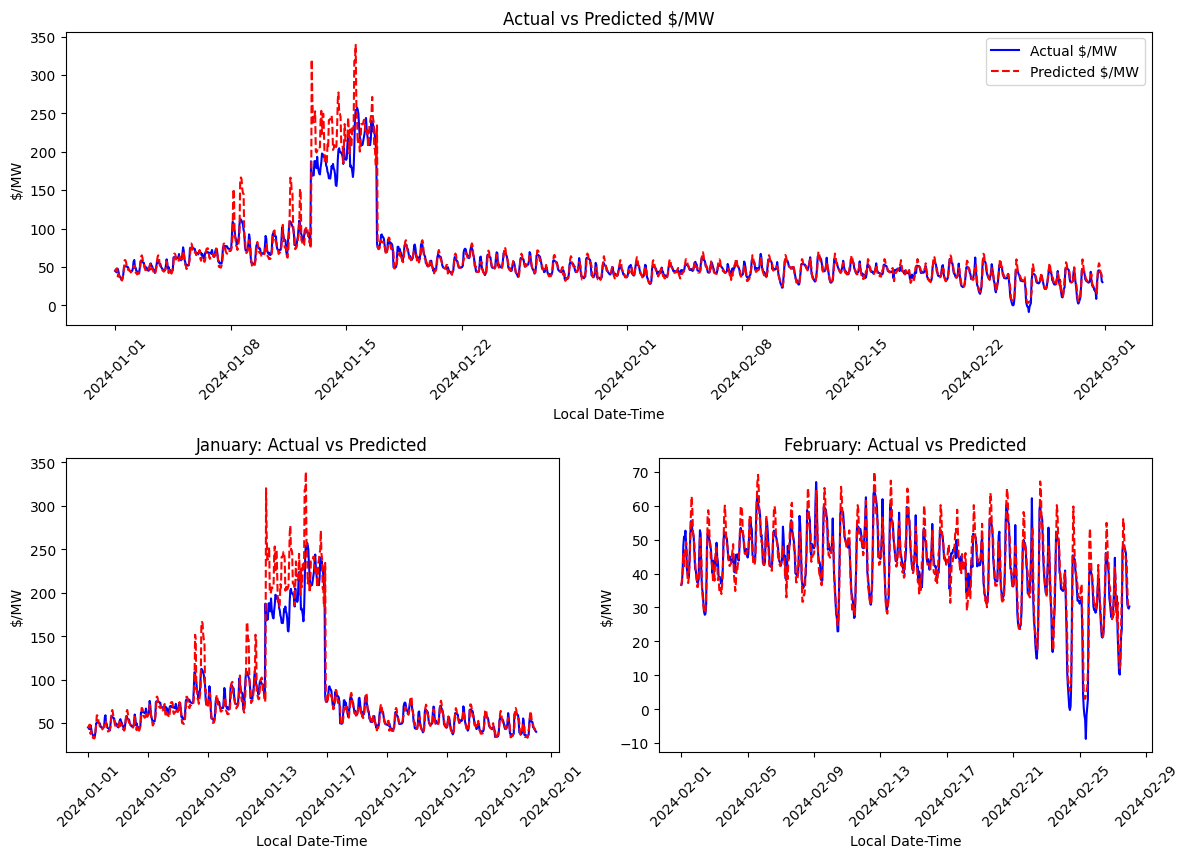

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

test_df_for_plotting = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_test.csv', usecols=['local_time'])
test_local_time = pd.to_datetime(test_df_for_plotting['local_time'])

if len(test_local_time) > len(y_test_pred):
    test_local_time = test_local_time[:len(y_test_pred)]

# Convert 'test_local_time' to datetime if it's not already
test_local_time = pd.to_datetime(test_local_time)

# Filter for January
january_start = "2024-01-01"
january_end = "2024-01-31"
is_january = (test_local_time >= january_start) & (test_local_time <= january_end)
january_times = test_local_time[is_january]
january_actual = y_test[is_january]
january_predictions = y_test_pred[is_january]

# Filter for February
february_start = "2024-02-01"
february_end = "2024-02-28"
is_february = (test_local_time >= february_start) & (test_local_time <= february_end)
february_times = test_local_time[is_february]
february_actual = y_test[is_february]
february_predictions = y_test_pred[is_february]

# Set up the plot layout
plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 2)  # Define a grid of 3 rows and 2 columns

# Main plot spanning the first row
ax0 = plt.subplot(gs[0, :])  # This subplot takes up the first row
ax0.plot(test_local_time, y_test, label='Actual $/MW', color='blue')
ax0.plot(test_local_time, y_test_pred, label='Predicted $/MW', color='red', linestyle='--')
ax0.set_title('Actual vs Predicted $/MW')
ax0.set_xlabel('Local Date-Time')
ax0.set_ylabel('$/MW')
ax0.legend()
ax0.tick_params(axis='x', rotation=45)

# January subplot in the second row, first column
ax1 = plt.subplot(gs[1, 0])  # Bottom left
ax1.plot(january_times, january_actual, label='Actual $/MW', color='blue')
ax1.plot(january_times, january_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax1.set_title('January: Actual vs Predicted')
ax1.set_xlabel('Local Date-Time')
ax1.set_ylabel('$/MW')
ax1.tick_params(axis='x', rotation=45)

# February subplot in the second row, second column
ax2 = plt.subplot(gs[1, 1])  # Bottom right
ax2.plot(february_times, february_actual, label='Actual $/MW', color='blue')
ax2.plot(february_times, february_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax2.set_title('February: Actual vs Predicted')
ax2.set_xlabel('Local Date-Time')
ax2.set_ylabel('$/MW')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()  # Adjust layout to make room for all elements
plt.show()

In [ ]:
print(len(test_local_time))  # Length of the datetime index
print(len(y_test))           # Length of the actual test labels
print(len(y_test_pred))      # Length of the predictions


1440
1437
1437


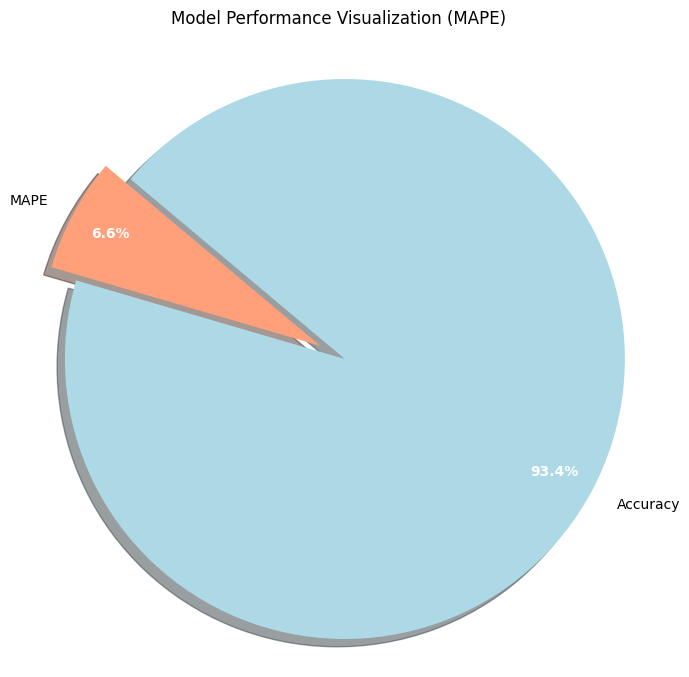

In [15]:
import matplotlib.pyplot as plt


remainder = 100 - mape_test  # Using MAPE to calculate the remainder

# Data to plot
labels = ['MAPE', 'Accuracy']
sizes = [mape_test, remainder]
colors = ['#FFA07A', '#ADD8E6']  # Light salmon for MAPE, Light blue for Accuracy
explode = (0.1, 0)  # Only "explode" the MAPE slice for emphasis

# Plot
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140, pctdistance=0.85)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Enhance the look & feel
plt.setp(texts, color='black')
plt.setp(autotexts, size=10, weight="bold", color="white")

plt.title('Model Performance Visualization (MAPE)', pad=20)
plt.show()


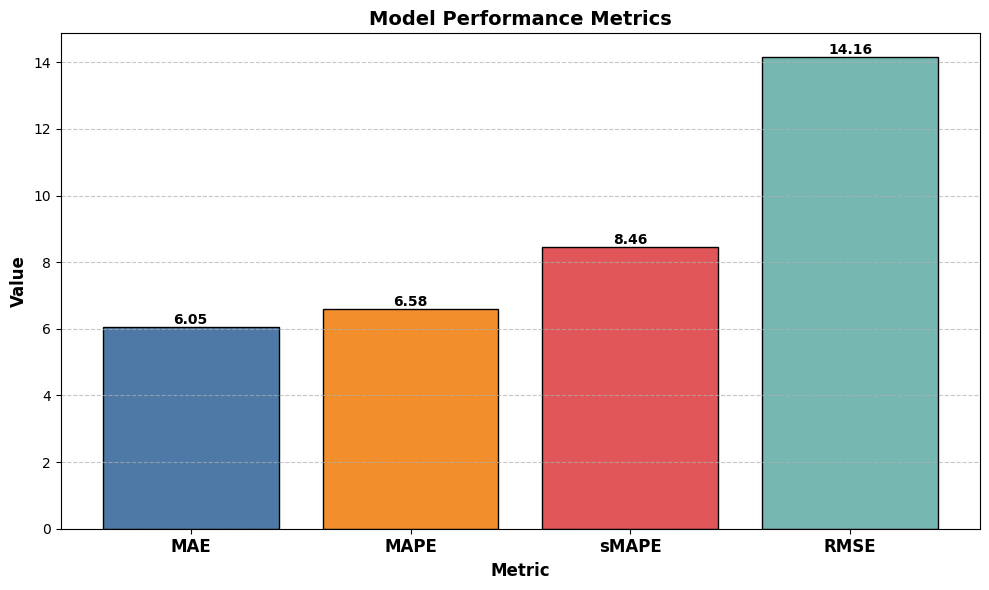

In [16]:
import matplotlib.pyplot as plt
import numpy as np


# Metric names
metrics_names = ['MAE', 'MAPE', 'sMAPE', 'RMSE']

# Creating an array with the positions of the bars along the x-axis
x_pos = np.arange(len(metrics_names))

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(x_pos, test_metrics, color=['#4E79A7', '#F28E2B', '#E15759', '#76B7B2'], edgecolor='black')

# Adding the metric names as labels on the x-axis
plt.xticks(x_pos, metrics_names, fontsize=12, fontweight='bold')

# Adding a title and labels for the axes
plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
plt.xlabel('Metric', fontsize=12, fontweight='bold')
plt.ylabel('Value', fontsize=12, fontweight='bold')

# Optional: Adding the value of each metric above its bar for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Adding gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

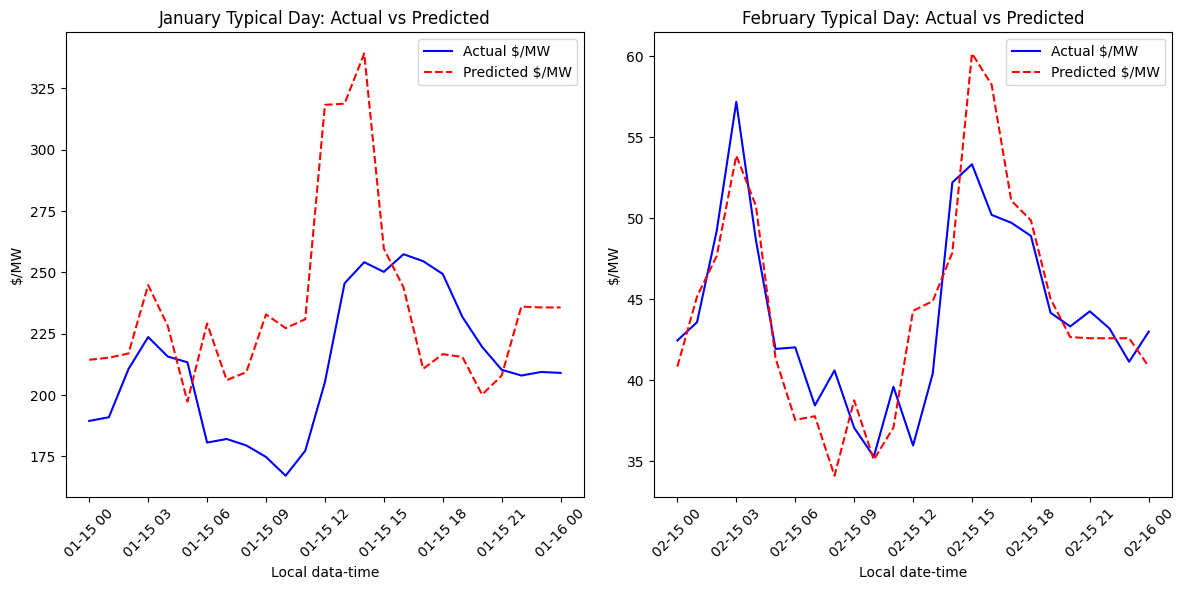

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Convert 'test_local_time' to datetime if it's not already
test_local_time = pd.to_datetime(test_local_time)

# Filter for January
january_start = "2024-01-15"
january_end = "2024-01-16"
is_january = (test_local_time >= january_start) & (test_local_time <= january_end)
january_times = test_local_time[is_january]
january_actual = y_test[is_january]
january_predictions = y_test_pred[is_january]

# Filter for February
february_start = "2024-02-15"
february_end = "2024-02-16"
is_february = (test_local_time >= february_start) & (test_local_time <= february_end)
february_times = test_local_time[is_february]
february_actual = y_test[is_february]
february_predictions = y_test_pred[is_february]

# Set up the plot layout
plt.figure(figsize=(12, 6))  # Adjusted for a wider aspect to accommodate two columns
gs = gridspec.GridSpec(1, 2)  # Adjusted to define a grid of 1 row and 2 columns

# January subplot in the first row, first column
ax1 = plt.subplot(gs[0, 0])  # Top left
ax1.plot(january_times, january_actual, label='Actual $/MW', color='blue')
ax1.plot(january_times, january_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax1.set_title('January Typical Day: Actual vs Predicted')
ax1.set_xlabel('Local data-time')
ax1.set_ylabel('$/MW')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# February subplot in the first row, second column
ax2 = plt.subplot(gs[0, 1])  # Top right
ax2.plot(february_times, february_actual, label='Actual $/MW', color='blue')
ax2.plot(february_times, february_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax2.set_title('February Typical Day: Actual vs Predicted')
ax2.set_xlabel('Local date-time')
ax2.set_ylabel('$/MW')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.tight_layout()  # Adjust layout to make room for all elements
plt.show()
